In [1]:
# =====================
# Imports
# =====================

from geocert import compute_boundary_batch, compute_l_inf_ball_batch, compute_l2_ball_batch, incremental_geocert
from plnn import PLNN
from _polytope_ import Polytope, from_polytope_dict
import utilities as utils
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from convex_adversarial import robust_loss

/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# apply incremental geocert to a normal and l1-regularized classifier. Finds maximal l_p balls
# for random points in R^2.

# ==================================
# Generate Training Points
# ==================================

print('===============Generating Training Points============')
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

layer_sizes = [2, 50, 8, 2]

===============Generating Training Points============


===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=10, bias=True)
  (4): ReLU()
  (5): Linear(in_features=10, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=2, bias=True)
)
===============Training Network============
tensor(0.6739) tensor(0.4167)


/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(0.4820) tensor(0.2500)
tensor(0.3900) tensor(0.1667)
tensor(0.2516) tensor(0.1667)
tensor(1.00000e-02 *
       7.8946) tensor(0.)
tensor(1.00000e-02 *
       2.5590) tensor(0.)
tensor(1.00000e-02 *
       1.1680) tensor(0.)
tensor(1.00000e-03 *
       6.6027) tensor(0.)
tensor(1.00000e-03 *
       4.2248) tensor(0.)
tensor(1.00000e-03 *
       2.9312) tensor(0.)


/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/torch/tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


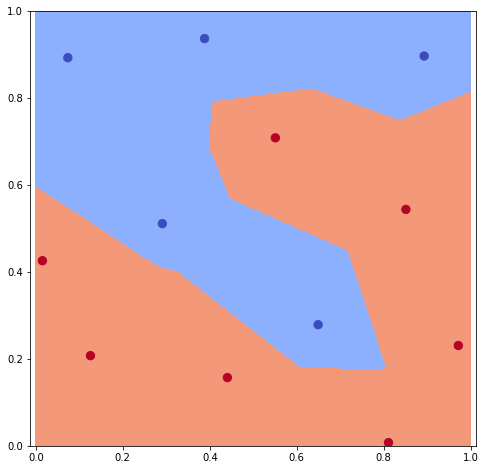

===============Collecting Polytopes============
number of polytopes: 169
===============Finding Classification Boundary Facets============


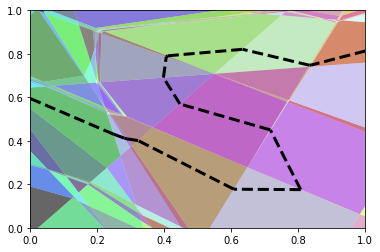

===============Finding Projection============
lp_norm:  l_2
tensor([[ 0.5508],
        [ 0.7081]])
from point: 
tensor([[ 0.5508],
        [ 0.7081]])
/home/justin/Github/geometric-certificates
---Initial Polytope---


/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)


num facets:  6
---Opening New Polytope---
num facets:  5


IndexError: list index out of range

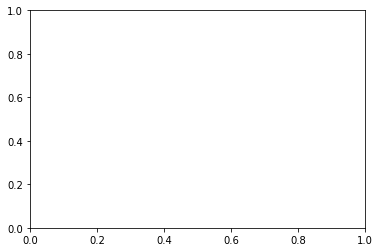

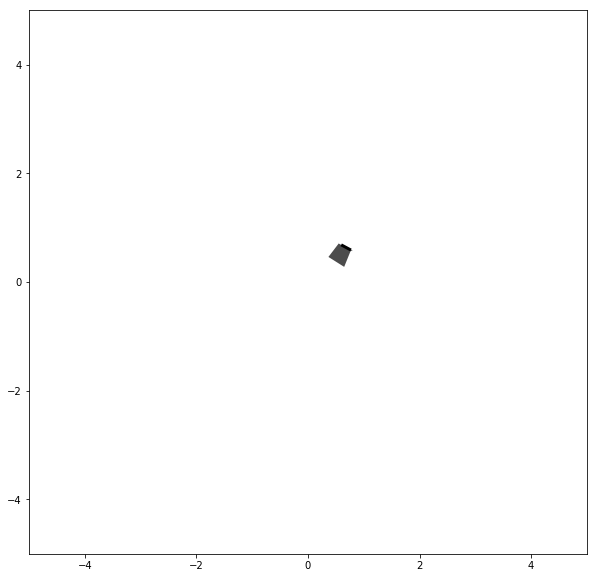

In [3]:
# ==================================
# Initialize Network
# ==================================

print('===============Initializing Network============')
# layer_sizes = [2, 8, 2]
network = PLNN(layer_sizes)
net = network.net


# ==================================
# Train Network
# ==================================

print('===============Training Network============')
opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    if i % 100 == 0:
        print(l.data[0], err)
    opt.zero_grad()
    (l).backward()
    opt.step()

# ==================================
# Visualize:  classifier boundary
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

plt.show()

# ==================================
# Visualize: baseline classifier ReLu regions
# ==================================

print('===============Collecting Polytopes============')
num_pts = 200
xylim = 1.0

unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
print('number of polytopes:', len(unique_bin_acts))
color_dict = utils.get_color_dictionary(unique_bin_acts)
polytope_list = []


for relu_configs, unique_act in zip(unique_relu_configs_list, unique_bin_acts):
    polytope_dict = network.compute_polytope_config(relu_configs, True)
    polytope = from_polytope_dict(polytope_dict)
    polytope_list.append(polytope)
    # colors.append(color_dict[unique_act])
colors = utils.get_spaced_colors(200)[0:len(polytope_list)]
x_0 = torch.Tensor([[0.3], [0.5]])

print('===============Finding Classification Boundary Facets============')

true_label = int(network(x_0).max(1)[1].item())  # what the classifier outputs

adversarial_facets = []
for polytope in polytope_list:
    polytope_adv_constraints = network.make_adversarial_constraints(polytope.config,
                                                                    true_label)

    for facet in polytope_adv_constraints:
        adversarial_facets.append(facet)


# ------------------------------
# Plot Polytopes, boundary, and lp norm
# ------------------------------

ax = plt.gca()
alpha = 0.6
xylim = 1.0

utils.plot_polytopes_2d(polytope_list, colors, alpha, xylim, ax)
utils.plot_facets_2d(adversarial_facets, xylim=xylim, ax=ax, color='black', linestyle='dashed')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()


# ==================================
# Find Projections
# ==================================

lp_norm = 'l_2'
ts = []
pts = x

for pt in pts:
    print('===============Finding Projection============')
    print('lp_norm: ', lp_norm)
    x_0 = torch.Tensor(pt.reshape([2, 1]))
    print(x_0)
    print('from point: ')
    print(x_0)

    ax = plt.axes()
    cwd = os.getcwd()
    print(cwd)
    plot_dir = cwd + '/plots/incremental_geocert/'

    t = incremental_geocert(lp_norm, network, x_0, ax, plot_dir)

    print('the final projection value:', t)
    ts.append(t)

# ==================================
# Visualize: incremental geocert projections
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

for pt, t, y in zip(pts, ts, y.numpy()):
    if lp_norm == 'l_2':
        utils.plot_l2_norm(pt, t, ax=ax)
    elif lp_norm == 'l_inf':
        utils.plot_linf_norm(pt, t, ax=ax)
    else:
        raise NotImplementedError

print('average_linf:', np.average(ts))

plt.show()

In [ ]:
# apply incremental geocert to a normal and l1-regularized classifier. Finds maximal l_p balls
# for random points in R^2.

# ==================================
# Generate Training Points
# ==================================

print('===============Generating Training Points============')
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

In [ ]:
# ==================================
# Initialize Network
# ==================================

print('===============Initializing Network============')
network = PLNN(layer_sizes)
net = network.net


# ==================================
# Train Network
# ==================================

def l1_loss(net):

    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])


print('===============Training Network with Regularization============')
opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y)).view([1])

    l1_scale = torch.Tensor([1e-4])
    l += l1_scale * l1_loss(net).view([1])

    err = (out.max(1)[1].data != y).float().mean()
    opt.zero_grad()
    (l).backward()
    opt.step()

print('error: ', err)



# ==================================
# Visualize:  classifier boundary
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

plt.show()

# ==================================
# Visualize: baseline classifier ReLu regions
# ==================================

print('===============Collecting Polytopes============')
num_pts = 200
xylim = 1.0

unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
print('number of polytopes:', len(unique_bin_acts))
color_dict = utils.get_color_dictionary(unique_bin_acts)
polytope_list = []


for relu_configs, unique_act in zip(unique_relu_configs_list, unique_bin_acts):
    polytope_dict = network.compute_polytope_config(relu_configs, True)
    polytope = from_polytope_dict(polytope_dict)
    polytope_list.append(polytope)
    # colors.append(color_dict[unique_act])
colors = utils.get_spaced_colors(200)[0:len(polytope_list)]
x_0 = torch.Tensor([[0.3], [0.5]])

print('===============Finding Classification Boundary Facets============')

true_label = int(network(x_0).max(1)[1].item())  # what the classifier outputs

adversarial_facets = []
for polytope in polytope_list:
    polytope_adv_constraints = network.make_adversarial_constraints(polytope.config,
                                                                    true_label)

    for facet in polytope_adv_constraints:
        adversarial_facets.append(facet)


# ------------------------------
# Plot Polytopes, boundary, and lp norm
# ------------------------------

ax = plt.gca()
alpha = 0.6
xylim = 1.0

utils.plot_polytopes_2d(polytope_list, colors, alpha, xylim, ax)
utils.plot_facets_2d(adversarial_facets, xylim=xylim, ax=ax, color='black', linestyle='dashed')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()


# ==================================
# Find Projections
# ==================================

lp_norm = 'l_2'
ts = []
pts = x

for pt in pts:
    print('===============Finding Projection============')
    print('lp_norm: ', lp_norm)
    x_0 = torch.Tensor(pt.reshape([2, 1]))
    print(x_0)
    print('from point: ')
    print(x_0)

    ax = plt.axes()
    cwd = os.getcwd()
    print(cwd)
    plot_dir = cwd + '/plots/incremental_geocert/'

    t = incremental_geocert(lp_norm, network, x_0, ax, plot_dir)

    print('the final projection value:', t)
    ts.append(t)

# ==================================
# Visualize: incremental geocert projections
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

for pt, t, y in zip(pts, ts, y.numpy()):
    if lp_norm == 'l_2':
        utils.plot_l2_norm(pt, t, ax=ax)
    elif lp_norm == 'l_inf':
        utils.plot_linf_norm(pt, t, ax=ax)
    else:
        raise NotImplementedError

print('average_linf:', np.average(ts))

plt.show()